# Create plots for panels used in figure 2

In [222]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

Examples how to plot the control probability cure in figure 2A can be found in `plots_fig1`

In [32]:
# folder to save all panels for figure 2
savefolder = r"plots\fig2"

# file containing the data for the controls
results_ctrl_file = r"data\shape_analysis\histograms_HealthyControl_deformed_undeformed.txt"

## Panel A

In [33]:
def asymptotic_exponential_growth(x, lambda_):
    """(Inverted) exponential growth function with maximum at 1 for x->infinity:
    f(x) = 1 - exp(-lambda * x)"""
    return 1 - np.exp(-lambda_ * x)

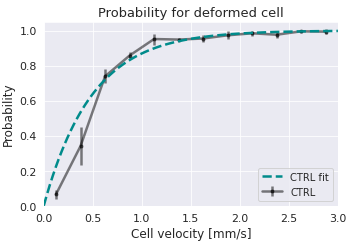

In [18]:
results_ctrl = np.loadtxt(results_ctrl_file)

label_fontsize = 12

v_min = 0.
v_max = 3.

v_ctrl = results_ctrl[:,0]
probs_ctrl = results_ctrl[:,3]
probs_ctrl_err = results_ctrl[:,4]

fit_bounds=(0, np.inf)

ind_vmax = v_ctrl <= v_max
v_ctrl = v_ctrl[ind_vmax]
probs_ctrl = probs_ctrl[ind_vmax]
probs_ctrl_err = probs_ctrl_err[ind_vmax]

popt_ctrl, pcov_ctrl = curve_fit(asymptotic_exponential_growth, v_ctrl, probs_ctrl,
                                 sigma = probs_ctrl_err, absolute_sigma=False,
                                 bounds = fit_bounds)

v_plot = np.linspace(v_min, v_max, 100)

with sns.axes_style("darkgrid"):
    plt.figure(0,(5,3.5))
    plt.errorbar(v_ctrl, probs_ctrl, probs_ctrl_err,
                 color='k', marker='.',
                 alpha=.5, lw=2.5, zorder=1, label='CTRL')
    plt.plot(v_plot, asymptotic_exponential_growth(v_plot, *popt_ctrl),
             color='darkcyan', ls='--', lw=2.5, zorder=100, label='CTRL fit')
    # plt.axhline(1, c='C0', ls='--', lw=1.5)
    # plt.vlines(0.5, -0.1, 0.5, ls='--', color='orange', lw=1.5)
    plt.xlim(0,3)
    plt.ylim(0,1.05)
    plt.xlabel("Cell velocity [mm/s]", fontsize=label_fontsize)
    plt.ylabel("Probability", fontsize=label_fontsize)
    plt.title("Probability for deformed cell", fontsize=label_fontsize+1)
    plt.tick_params(labelsize=label_fontsize-1)
    plt.legend(loc='lower right')
    plt.tight_layout()

    savename = "fig2A_explain_FitValues"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

## Panels B-D

In [34]:
#define a color seed for each patient
color_dict = {'VS': 'C0', 'VL': 'C1', 'RS': 'C2',
              'KM': 'C3', 'LM': 'C4'}

In [35]:
def deformed_probability_curve(df, v_min=0, v_max=3, binsize=.25):
    """Compute the values for the shape probability diagram to find a cell
    in a deformed state for velocities between v_min and v_max in the DataFrame df

    returns: *tuple* (deformed_bins, deformed_hist_normal)
        - deformed_bins: *array* limits for the bin ranges of the histogram
        - normalized counts for each velocity range
    """

    bins = int(v_max/binsize)   #number of Bins in histogram
    #find index of cells in a deformed state. Class definitions are:
    #1-parachute, 2-slipper, 3-asym. parachute, 5-multilobe, 7-undefined deformed
    #4-discocyte/undeformed, 6-tumbler
    deformed_index = ((df['shape'] == 1)
                      | (df['shape'] == 2)
                      | (df['shape'] == 3)
                      | (df['shape'] == 5)
                      | (df['shape'] == 7))

    #create new column in df that is True for deformed state
    df['deformed'] = False
    df['deformed'][deformed_index] = True

    df_deformed = df[deformed_index]

    deformed_hist, deformed_bins = np.histogram(np.array(df_deformed['velocity']),
                                                range = (v_min,v_max),
                                                bins = bins)
    #get the counts for all events to use for normalization
    all_hist, all_bins = np.histogram(np.array(df['velocity']),
                                      range = (v_min,v_max),
                                      bins = bins)

    #normalize the deformed histogram
    deformed_hist_normal = deformed_hist/all_hist

    return deformed_bins, deformed_hist_normal

In [92]:
#define dict to store fit values
dict_fitvalues = {}

def dict_fit_values_patient(patient, dict_fitvalues):
    result_summary_folder = r"data\shape_analysis\result_summaries"

    v_min = 0.
    v_max = 3.
    binsize = 0.25

    # bounds of the parameters in the exponential growth function
    fit_bounds=(0, np.inf)

    result_file = os.path.join(result_summary_folder, patient + "_results_MCFM.tsv")
    df_results = pd.read_csv(result_file, sep='\t')

    dates = np.unique(df_results['date'])
    dates = np.sort(dates)
    day0 = pd.to_datetime(dates[0])

    #create dataframes to save fit parameters
    df_fit_all = pd.DataFrame()
    df_fit_healthy = pd.DataFrame()
    df_fit_unhealthy = pd.DataFrame()

    for num, date in enumerate(dates):
        df_date = df_results[df_results['date']==date]
        #create new Dataframe to work with, leave out skipped cells
        df = df_date[df_date['shape'] != 0]

        healthy_index = df['health'] == 0
        df_healthy = df[healthy_index]
        unhealthy_index = df['health'] == 1
        df_unhealthy = df[unhealthy_index]

        #calculate percentage of healthy cells in sample
        percentage_healthy = len(df_healthy)/len(df)

        bins, deformed_curve = deformed_probability_curve(df, v_min=v_min, v_max=v_max, binsize=binsize)
        bins_healthy, deformed_curve_healthy =  deformed_probability_curve(df_healthy,
                                                                           v_min=v_min, v_max=v_max, binsize=binsize)
        bins_unhealthy, deformed_curve_unhealthy =  deformed_probability_curve(df_unhealthy,
                                                                               v_min=v_min, v_max=v_max, binsize=binsize)

        bins_plot = bins[:-1]+binsize/2

        #exclude nan values before fitting
        ind_nonnan_all = ~np.isnan(deformed_curve)
        ind_nonnan_healthy = ~np.isnan(deformed_curve_healthy)
        ind_nonnan_unhealthy = ~np.isnan(deformed_curve_unhealthy)

        x_all = bins_plot[ind_nonnan_all]
        y_all = deformed_curve[ind_nonnan_all]
        x_healthy = bins_plot[ind_nonnan_healthy]
        y_healthy = deformed_curve_healthy[ind_nonnan_healthy]
        x_unhealthy = bins_plot[ind_nonnan_unhealthy]
        y_unhealthy = deformed_curve_unhealthy[ind_nonnan_unhealthy]

        popt_all_exp, pcov_all_exp = curve_fit(asymptotic_exponential_growth,
                                               x_all, y_all,
                                               bounds=fit_bounds
                                               )
        popt_healthy_exp, pcov_healthy_exp = curve_fit(asymptotic_exponential_growth,
                                                       x_healthy, y_healthy,
                                                       bounds=fit_bounds
                                                       )

        if 'CTRL' not in patient:
            popt_unhealthy_exp, pcov_unhealthy_exp = curve_fit(asymptotic_exponential_growth,
                                                               x_unhealthy, y_unhealthy,
                                                               bounds=fit_bounds
                                                               )
        #days since treatment start
        treatment_days = (pd.to_datetime(date) - day0).days

        df_fit_all = df_fit_all.append({'lambda': popt_all_exp[0], 'lambda_err': np.sqrt(pcov_all_exp[0,0]),
                                        'days': treatment_days,
                                        'percent healthy': percentage_healthy
                                        },
                                       ignore_index=True)
        df_fit_healthy = df_fit_healthy.append({'lambda': popt_healthy_exp[0], 'lambda_err': np.sqrt(pcov_healthy_exp[0,0]),
                                                'days': treatment_days
                                                },
                                               ignore_index=True)
        if 'CTRL' not in patient:
            df_fit_unhealthy = df_fit_unhealthy.append({'lambda': popt_unhealthy_exp[0], 'lambda_err': np.sqrt(pcov_unhealthy_exp[0,0]),
                                                        'days': treatment_days
                                                        },
                                                       ignore_index=True)
    if 'CTRL' in patient:
        dict_fitvalues[patient] = {'all': df_fit_all, 'healthy': df_fit_healthy}
    else:
        dict_fitvalues[patient] = {'all': df_fit_all, 'healthy': df_fit_healthy, 'unhealthy': df_fit_unhealthy}

    return dict_fitvalues

Fill dictionary with patient data

In [101]:
patients = ['CTRL_1', 'CTRL_2','CTRL_3','VS', 'VL', 'RS', 'LM', 'KM']
labels = ["CTRL 1", "CTRL 2","CTRL 3", "P1", "P2", "P3", "P4", "P5"]

for patient in patients:
    dict_fitvalues = dict_fit_values_patient(patient, dict_fitvalues)

### B: $\lambda$ for baseline normocytes

In [123]:
patients = ['CTRL_1', 'CTRL_2','CTRL_3','VS', 'VL', 'RS', 'LM', 'KM']
labels = ["CTRL 1", "CTRL 2","CTRL 3", "P1", "P2", "P3", "P4", "P5"]

df_baseline_normocytes_all = pd.DataFrame()

for ii, patient in enumerate(patients):
    df_normocytes_patient = dict_fitvalues[patient]['healthy']
    baseline_idx = df_normocytes_patient['days']==0
    df_normocytes_patient_baseline = df_normocytes_patient[baseline_idx]
    df_normocytes_patient_baseline['patient'] = labels[ii]

    if 'CTRL' in patient:
        df_normocytes_patient_baseline['patient type'] = 'CTRL'
        df_normocytes_patient_baseline['hue'] = 'CTRL'
    else:
        df_normocytes_patient_baseline['patient type'] = 'ChAc'
        df_normocytes_patient_baseline['hue'] = labels[ii]

    df_baseline_normocytes_all = df_baseline_normocytes_all.append(df_normocytes_patient_baseline)

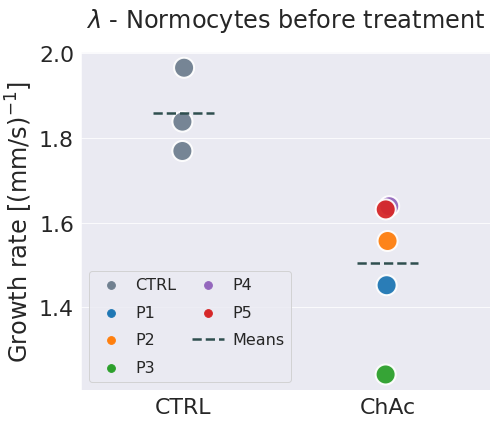

In [238]:
fontsize_labels = 24

# adapt new color palette, so that P4 is purple and P5 is red
color_ctrl = 'slategray' #sns.color_palette('Set2')[7] #color for the control sample
pal_custom = sns.color_palette('tab10', 5)
palette = pal_custom.copy()
palette[3] = pal_custom[4]
palette[4] = pal_custom[3]
palette.insert(0, color_ctrl)

with sns.axes_style('darkgrid'):
    f, ax = plt.subplots(figsize=(7,6))

    # plot the mean line
    sns.boxplot(data=df_baseline_normocytes_all, x='patient type', y='lambda',
                width=.3,
                showmeans=True,
                meanline=True,
                meanprops={'color': 'darkslategray', 'ls': '--', 'lw': 2.5, 'label': 'Means'},
                medianprops={'visible': False},
                whiskerprops={'visible': False},
                zorder=10,
                showfliers=False,
                showbox=False,
                showcaps=False,
                ax=ax)
    sns.stripplot(data=df_baseline_normocytes_all, x='patient type', y='lambda',
                  hue='hue', palette=palette, jitter=.01,
                  marker='o', edgecolor='w', linewidth=2, size=20, alpha=.95,
                  zorder=0,
                  ax=ax)

    ax.set_xlabel("", fontsize = fontsize_labels)
    ax.set_ylabel(r"Growth rate [(mm/s)$^{-1}$]", fontsize = fontsize_labels)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_labels-2)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_labels-2)

    handles, labels = ax.get_legend_handles_labels()
    handles = np.roll(handles[1:], -1)
    labels = np.roll(labels[1:], -1)
    ax.legend(handles, labels, ncol=2,
              labelspacing=.8, handletextpad=0.5, columnspacing=1,
              loc='lower left', title="", fontsize=16)

    ax.set_title(r"$\lambda$ - Normocytes before treatment", fontsize=fontsize_labels, pad=25)

    plt.tight_layout()

    savename = "fig2B_growth_rate_baseline"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

In [226]:
y_para = 'lambda'

df_ctrl = df_baseline_normocytes_all[df_baseline_normocytes_all['patient type'] == 'CTRL']
df_chac = df_baseline_normocytes_all[df_baseline_normocytes_all['patient type'] == 'ChAc']

t_statistic, p_value_ttest = ttest_ind(df_ctrl[y_para], df_chac[y_para],
                                       equal_var=True  # set false, if variance differs
                                       )
t_statistic_welch, p_value_welch = ttest_ind(df_ctrl[y_para], df_chac[y_para],
                                             equal_var=False  # set false, if variance differs
                                             )

print("p-value = ", p_value_ttest)
print("p-value = ", p_value_welch)

p-value =  0.016236766221251215
p-value =  0.009323080468727069


### C-D: $\lambda$ during dasatinib treatment for normocytes and acanthocytes

Plot data for P1-P3

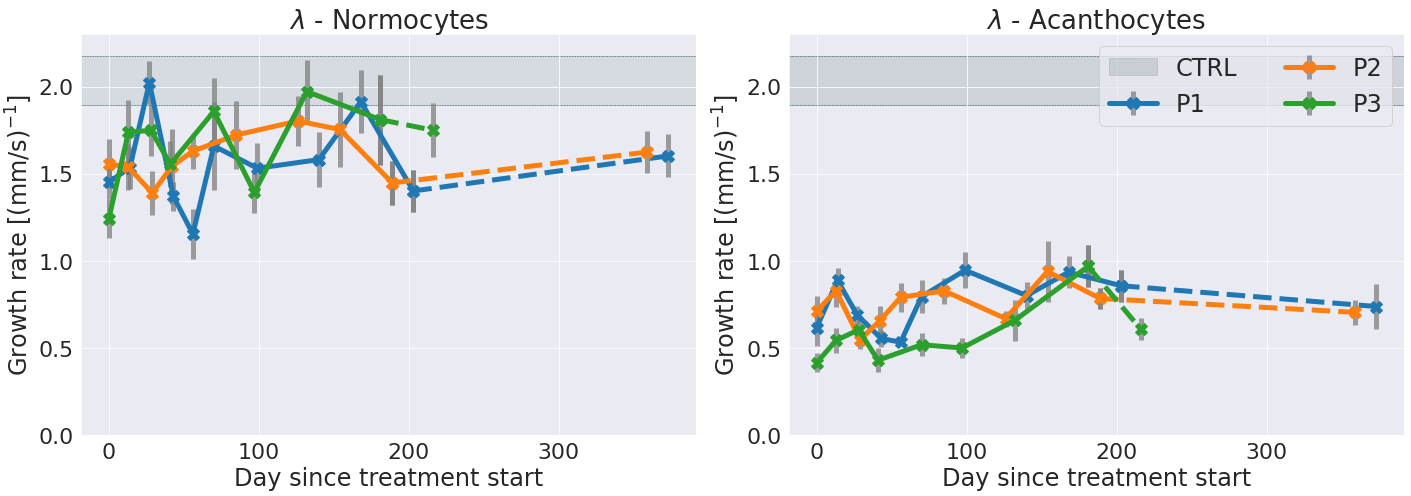

In [246]:
patients = ['VS', 'VL', 'RS']
labels = ["P1", "P2", "P3"]

# plot variables
figsize = (20,7)
fontsize = 24
linewidth = 5
markersize = 12
errbar_width = 5
xlabel = 'Day since treatment start'

# color for the control interval
ctrl_clr = 'darkslategray'

# compute control fit values
results_ctrl = np.loadtxt(results_ctrl_file)

v_ctrl = results_ctrl[:,0]
probs_ctrl = results_ctrl[:,3]
probs_ctrl_err = results_ctrl[:,4]

v_min = 0.
v_max = 3.
binsize = 0.25
bins = int(v_max / binsize)

ind_vmax = v_ctrl <= v_max
v_ctrl = v_ctrl[ind_vmax]
probs_ctrl = probs_ctrl[ind_vmax]
probs_ctrl_err = probs_ctrl_err[ind_vmax]

fit_bounds = [0, np.inf]
popt_ctrl, pcov_ctrl = curve_fit(asymptotic_exponential_growth, v_ctrl, probs_ctrl,
                                 sigma = probs_ctrl_err, absolute_sigma=False,
                                 bounds=fit_bounds
                                 )
perr_ctrl = np.sqrt(np.diag(pcov_ctrl))

# limits of the 95% confidence interval
ci_lower = float(popt_ctrl - perr_ctrl)
ci_upper = float(popt_ctrl + perr_ctrl)

with sns.axes_style('darkgrid'):

    fig = plt.figure(0,figsize)

    plot_titles = ['Normocytes', 'Acanthocytes']
    para = 'lambda'
    para_label = r'$\lambda$'
    ylim = [0, 2.3]

    for jj, patient in enumerate(patients):
        data = dict_fitvalues[patient]
        color = color_dict[patient]

        for n, health in enumerate(['healthy', 'unhealthy']):
            ax=plt.subplot(1,2,n+1)

            df_plot = data[health]
            xdata = df_plot['days']
            ydata = df_plot[para]
            yerr = df_plot[para + "_err"]

            # plot data on treatment
            plt.errorbar(xdata[:-1], ydata[:-1], yerr=yerr[:-1],
                         c=color, label=labels[jj],
                         ls='-', lw=linewidth, marker='X', markersize=markersize,
                         ecolor='gray', elinewidth=errbar_width)

            # plot data off treatment
            plt.errorbar(xdata[-2:], ydata[-2:], yerr=yerr[-2:],
                         c=color, ls='--', lw=linewidth, marker='X', markersize=markersize,
                         ecolor='gray', elinewidth=errbar_width)

            plt.ylim(ylim)
            plt.xlabel(xlabel, fontsize=fontsize)
            plt.tick_params(axis='both', which='both', labelsize=fontsize-2)
            plt.xticks([0,100,200,300])
            plt.title(r'{} - {}'.format(para_label, plot_titles[n]), fontsize=fontsize+2)

            # plot control region at end only
            if patient==patients[-1]:
                if health=='unhealthy':
                    ax.axhline(ci_lower, ls='--', lw=.5, c=ctrl_clr, zorder=0)
                    ax.axhline(ci_upper, ls='--', lw=.5, c=ctrl_clr, zorder=0)
                    axis_limits = ax.get_xlim()
                    ax.add_patch(patches.Rectangle((axis_limits[0], ci_lower),
                                                   np.diff(axis_limits), ci_upper-ci_lower,
                                                   color=ctrl_clr, alpha=0.15, zorder=0,
                                                   label = 'CTRL'
                                                   )
                                 )
                    # ax.get_yaxis().set_ticklabels([])

                else:
                    ax.axhline(ci_lower, ls='--', lw=.5, c=ctrl_clr, zorder=0)
                    ax.axhline(ci_upper, ls='--', lw=.5, c=ctrl_clr, zorder=0)
                    axis_limits = ax.get_xlim()
                    ax.add_patch(patches.Rectangle((axis_limits[0], ci_lower),
                                                   np.diff(axis_limits), ci_upper-ci_lower,
                                                   color=ctrl_clr, alpha=0.1, zorder=0,
                                                   )
                                 )
            # set alpha of errorbars
            for collection in ax.collections:
                collection.set_alpha(.75)

    ax1, ax2 = fig.axes
    y_label = "Growth rate [(mm/s)$^{-1}$]"
    ax1.set_ylabel(y_label, fontsize=fontsize)
    ax2.set_ylabel(y_label, fontsize=fontsize)
    # fig.supylabel("Growth rate [(mm/s)$^{-1}$]", fontsize=fontsize)

    plt.legend(loc='upper right', ncol=2, fontsize=fontsize)
    plt.tight_layout(rect=(0.015,0,1,1))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.15, hspace=None)

    savename = "fig2C_growth_rate_dasatinib"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

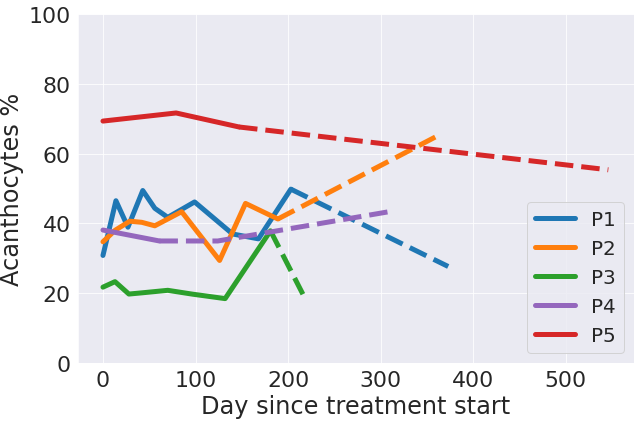

In [87]:
patients = ['VS', 'VL', 'RS', 'LM', 'KM']
labels = ["P1", "P2", "P3", "P4", "P5"]

fontsize = 22
lw = 5
xlabel = 'Day since treatment start'

with sns.axes_style('darkgrid'):
    plt.figure(0,(9,6))

    for jj, patient in enumerate(patients):
        data = dict_fitvalues[patient]
        color = color_dict[patient]

        # plot percentage of acanthocytes
        df_all = data['all']

        if patient=='LM':
            plt.plot(df_all['days'][:-2], (1-df_all['percent healthy'][:-2])*100, c=color, lw=lw, label=labels[jj])
            plt.plot(df_all['days'][-3:], (1-df_all['percent healthy'][-3:])*100, '--', lw=lw, c=color)
        else:
            plt.plot(df_all['days'][:-1], (1-df_all['percent healthy'][:-1])*100, c=color, lw=lw, label=labels[jj])
            plt.plot(df_all['days'][-2:], (1-df_all['percent healthy'][-2:])*100, '--', lw=lw, c=color)

    plt.ylim(0,100)
    plt.xlabel(xlabel, fontsize=fontsize+2)
    plt.ylabel("Acanthocytes %", fontsize=fontsize+2)
    plt.tick_params(axis='both', which='both', labelsize=fontsize)

    # plt.autoscale()
    plt.legend(fontsize=fontsize-2, ncol=1)
    plt.tight_layout()

    savename = "fig2E_treatment_acantho_count"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')

## Panel F

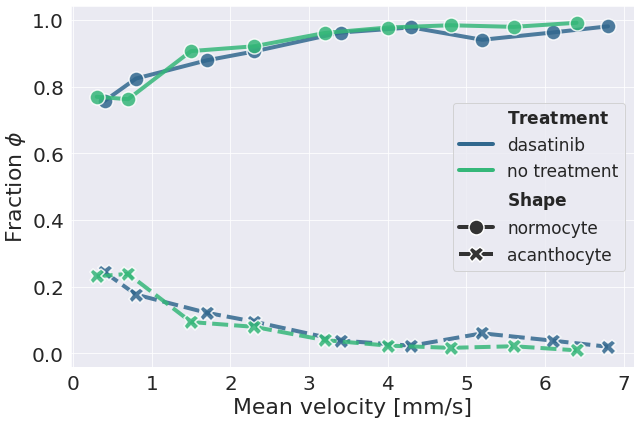

In [11]:
# read in vitro study data
path_in_vitro = r"data\shape_analysis\data_in_vitro_dasa_treatment.xlsx"
df_in_vitro = pd.read_excel(path_in_vitro)

# plot parameters
linewidth = 4
markersize = 15
markerwidth = 1.5
fontsize = 20

markers = 'treatment'
with sns.axes_style('darkgrid'):
    fig = plt.figure(0,(9,6))
    ax = plt.subplot(111)

    sns.lineplot(x='mean velocity [mm/s]', y='fraction', data=df_in_vitro,
                 hue='treatment', style='shape', markers=True,
                 ax=ax, palette='viridis',
                 linewidth=linewidth, markersize=markersize, markeredgewidth=markerwidth,
                 alpha=.85
                 )

    ax.xaxis.label.set_size(fontsize+2)
    ax.set_xlabel(r"Mean velocity [mm/s]", fontsize=fontsize+2)
    ax.set_ylabel(r"Fraction $\phi$", fontsize=fontsize+2)
    ax.tick_params(axis='both', labelsize=fontsize)

    handles, labels = ax.get_legend_handles_labels()
    label = r"$\bf{Treatment}$"
    labels[0] = label
    labels[3] = r"$\bf{Shape}$"

    handles_new = []
    for handle in handles:
        if handle.get_color() == 'w':
            handle.set_linewidth(0)
        else:
            handle.set_linewidth(linewidth)
        handle.set(markersize=markersize,
                   markeredgewidth=markerwidth,
                   markeredgecolor='w')
        handles_new.append(handle)

    leg = plt.legend(handles_new, labels, ncol=1, fontsize=fontsize-3)

    plt.tight_layout()
    savename = "fig2F_in_vitro_dasa_treatment"
    savepath = os.path.join(savefolder,savename)
    plt.savefig(savepath+".pdf", dpi=900, format='pdf')